# Active Learning

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
X, y = make_blobs(n_samples=5000, centers=2, n_features=4,cluster_std=2.0,center_box=(-5.0, 5.0),random_state=0)

In [3]:
cols = ["feature_1","feature_2","feature_3","feature_4"]
df = pd.DataFrame(data=X,columns=cols)
df["label"] = y

In [4]:
def plot_data(df):
    plt.figure(figsize=(18,9))
    plt.subplot(221)
    sns.scatterplot(x=cols[0], y=cols[3],hue="label",data=df)
    plt.subplot(222)
    sns.scatterplot(x=cols[1], y=cols[3],hue="label",data=df)
    plt.grid(True)

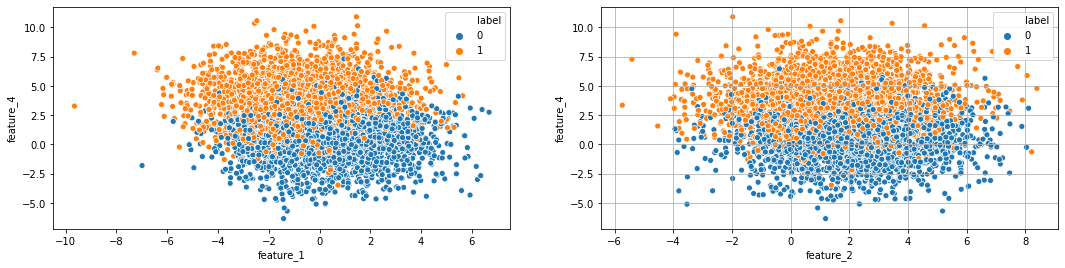

In [5]:
plot_data(df)

## O Problema

O seu trabalho é bem simples: dado um dataset você precisa criar um classificador. Certo problemas, certo? Você conhece diversas técnicas de classificação, sejam supervisionadas ou não-supervisionadas. Talvez você já tenha até um pipeline próprio pronto para ser utilizado, maravilha.
Entretanto, o mundo real te preparou uma supresa: o seu dataset além de ter um número elevado de observações (dezenas de milhões talvez) e possuir muitas features (curse of dimensionality) não está rotulado e o seu cliente tem em mente algumas classes específicas. Vejamos:
- Simplemente clusterizar os dados não resolverá o problema, pois nada garante que os clusters corresponderão às classes desejadas
- Podemos tentar com diversas técnicas e parâmetros analisando os clusters até que eles se encaixem nas classes desejadas, mas novamente não temos garantia e isso pode tomar muito tempo
- Caso exista um especialista nestes dados capaz de identificar a classe verdadeira ao observar um datapoint, podemos pedir que este classifique algumas observações escolhidas ao acaso e a partir disso construir um modelo que generalize a partir destes dados anotados

Esse último ponto parece interessante, mas com milhões de observações o conjunto mínimo de observações rotuladas pode ainda ser grande a ponto de inviabilizar esta opção. 

E se as observações não fossem escolhidas ao acaso? E se houver uma estratégia para escolher as observações que serão mais informativas para o modelo que pretendemos criar? Bom, há meios de realizar isso, esse conjunto de técnicas é conhecida como Active Learning.

## Estratégia para fazer Active Learning

Podemos seguir uma receita simples:
1. Selecionamos ao acaso um subconjunto de dados pequeno
2. Pedimos que o especialista (Oracle) o rotule
3. Com estes dados treinamos um modelo supervisionado, chamamos o modelo de Learner
4. O Learner deve ser capaz de nos informar de alguma maneira a dúvida (incerteza) que ele tem quanto a verdadeira classe de cada observação
5. Pedimos que o Oracle rotule algumas das observações que o Learner tem mais incerteza, de acordo com algum critério de priorização
6. Repetimos os passos 3, 4 e 5 até que estejamos satisfeitos ou até que o Learner um determinado nível de certeza (critério de parada)

In [145]:
def plot_evolution(df,df2):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    sns.scatterplot(x=cols[0], y=cols[3],hue="label",data=df2)
    plt.grid(True)
    plt.subplot(132)
    sns.scatterplot(x=cols[0], y=cols[3],hue="m_label",data=df2)
    plt.subplot(133)
    sns.scatterplot(x="ignorance", y="entropy",hue="label",data=df2)
    plt.grid(True)
    plt.show()

def plot_exp(exp_params):
    plt.figure(figsize=(20,6))
    exp_id  = exp_params[0]
    name = exp_params[1]
    plt.plot(np.array(exp_1[exp_id]),label=f"Priorizando Entropia: {exp_1[exp_id][-1]:.4f}")
    plt.plot(np.array(exp_2[exp_id]),label=f"Priorizando Ignorância: {exp_2[exp_id][-1]:.4f}")
    plt.plot(np.array(exp_3[exp_id]),label=f"Priorizando Entr. + Ignor.: {exp_3[exp_id][-1]:.4f}")
    plt.plot(np.array(exp_4[exp_id]),label=f"Priorizando aleatoriamente: {exp_4[exp_id][-1]:.4f}")
    if name != "Ignorância":
        plt.plot(np.array(exp_5[exp_id]),label=f"Priorizando Ignor. mod: {exp_5[exp_id][-1]:.4f}")
        plt.plot(np.array(exp_6[exp_id]),label=f"Priorizando Entr. + Ignor. mod: {exp_6[exp_id][-1]:.4f}")
    plt.title(f"{name}")
    plt.xlabel("runs")
    plt.legend(loc=0)
    plt.grid(True)
    plt.show()

def oracle(ids_list,truth=df):
    return truth.iloc[ids_list]["label"]

def query_oracle(df2,ids2query=None,n=10):
    if ids2query:
        df2.loc[ids2query,"label"] = oracle(ids2query)
    else:
        ids2query = df2[df2.label==-1].sample(n).index.tolist()
        df2.loc[ids2query,"label"] = oracle(ids2query)
    return df2

def entropy(arr):
    arr = np.array(arr)
    epsilon = 0.000001
    return np.sum(-arr*np.log(arr+epsilon))

def run_experiment(strategy="random",runs=100,df=df,show=False):
    df2 = df.copy()
    ids2query = None
    df2["label"] = -1
    entropy_,ignorance_,priorisation_ = [[],[],[]]
    FP_, FN_, roc_ = [[],[],[]]
    n = 50
    for i in range(runs):
        df2 = query_oracle(df2,ids2query=ids2query,n=n)
        n=10
        model = LGBMClassifier(random_state=42,n_jobs=-1)
        model.fit(df2[df2["label"]!=-1][cols],df2[df2["label"]!=-1]["label"])
        df2["m_label"] = model.predict(df2[cols])
        df2["probabilities"] = model.predict_proba(df2[cols]).tolist()
        df2["entropy"] = df2["probabilities"].apply(entropy)
        df2["ignorance"] = silhouette_samples(df2[cols],df2["m_label"])
        entropy_.append(df2["entropy"].sum())
        df2["entropy"] = df2["entropy"]/df2["entropy"].max()
        df2["ignorance"] = 1-df2["ignorance"]**2
        ignorance_.append(df2["ignorance"].sum())    
        df2["priorisation"] = df2["entropy"]*df2["ignorance"]
        if strategy != "random":
            ids2query = df2[df2["label"]==-1].sort_values(by=strategy,ascending=False).index.tolist()[:10]
        _, FP, FN, _ = confusion_matrix(df['label'],df2['m_label']).ravel()
        roc_.append(roc_auc_score(df['label'],df2['m_label']))
        FP_.append(FP)
        FN_.append(FN)
    if show == True:
        plot_evolution(df,df2)
    return entropy_,ignorance_,FP_,FN_,roc_
    
def run_modified_experiment(strategy="random",runs=100,df=df,show=False):
    df2 = df.copy()
    ids2query = None
    df2["label"] = -1
    entropy_,ignorance_,priorisation_ = [[],[],[]]
    FP_, FN_, roc_ = [[],[],[]]
    n = 50
    for i in range(runs):
        df2 = query_oracle(df2,ids2query=ids2query,n=n)
        n=10
        model = LGBMClassifier(random_state=42,n_jobs=-1)
        model.fit(df2[df2["label"]!=-1][cols],df2[df2["label"]!=-1]["label"])
        df2["m_label"] = model.predict(df2[cols])
        df2["probabilities"] = model.predict_proba(df2[cols]).tolist()
        df2["entropy"] = df2["probabilities"].apply(entropy)
        df2["ignorance"] = silhouette_samples(df2[cols],df2["m_label"])
        entropy_.append(df2["entropy"].sum())
        df2["entropy"] = df2["entropy"]/df2["entropy"].max()
        df2["ignorance"] = -df2["ignorance"]
        ignorance_.append(df2["ignorance"].sum())    
        df2["priorisation"] = df2["entropy"]*df2["ignorance"]
        if strategy != "random":
            ids2query = df2[df2["label"]==-1].sort_values(by=strategy,ascending=False).index.tolist()[:10]
        _, FP, FN, _ = confusion_matrix(df['label'],df2['m_label']).ravel()
        roc_.append(roc_auc_score(df['label'],df2['m_label']))
        FP_.append(FP)
        FN_.append(FN)
    if show == True:
        plot_evolution(df,df2)
    return entropy_,ignorance_,FP_,FN_,roc_

### Para visualizar o resultado da clusterização de um experimento

Exp 1: entropia


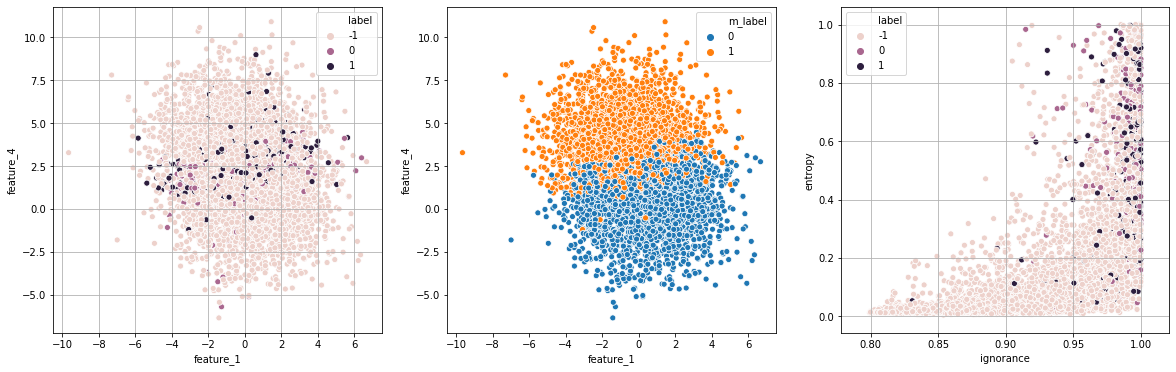

Exp 2: ignorância


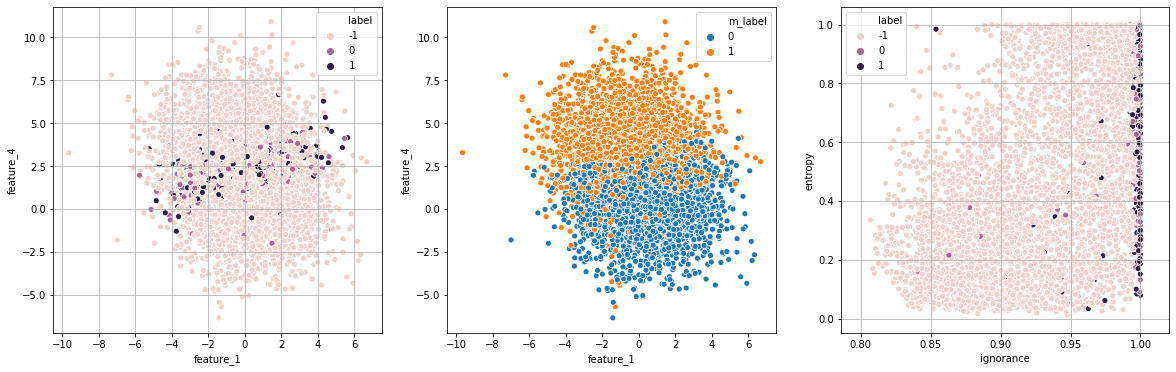

Exp 3: entropia + ignorância


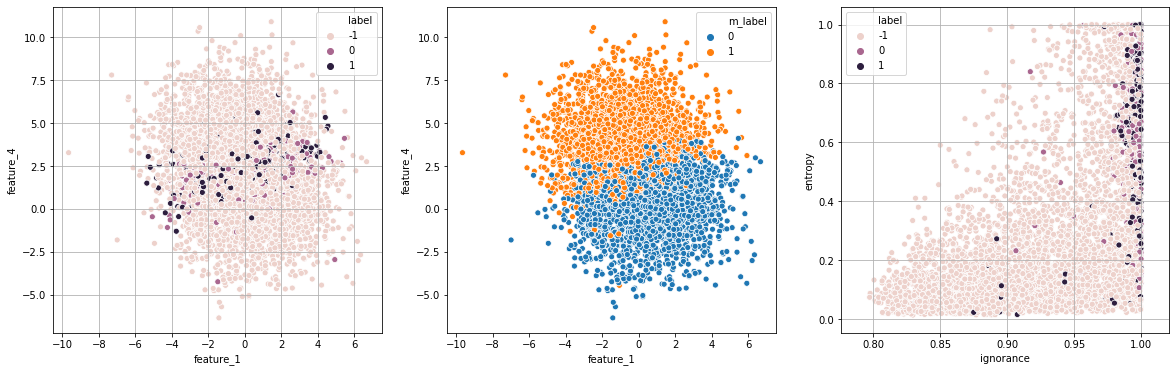

Exp 4: aleatório


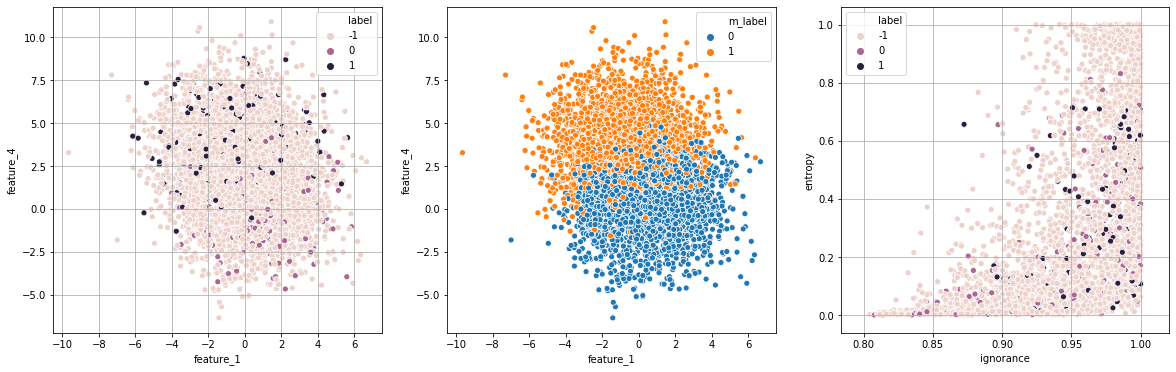

Exp 5: ignorância modificada


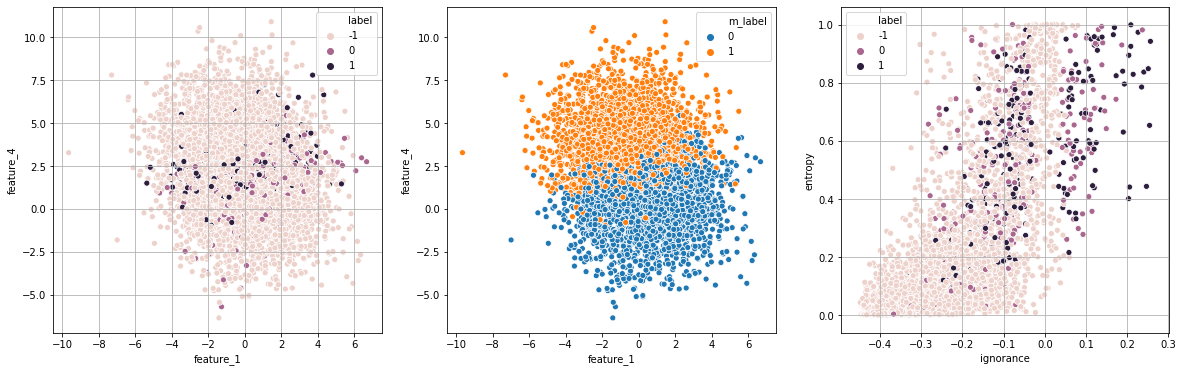

Exp 6: entropia + ignorância modificada


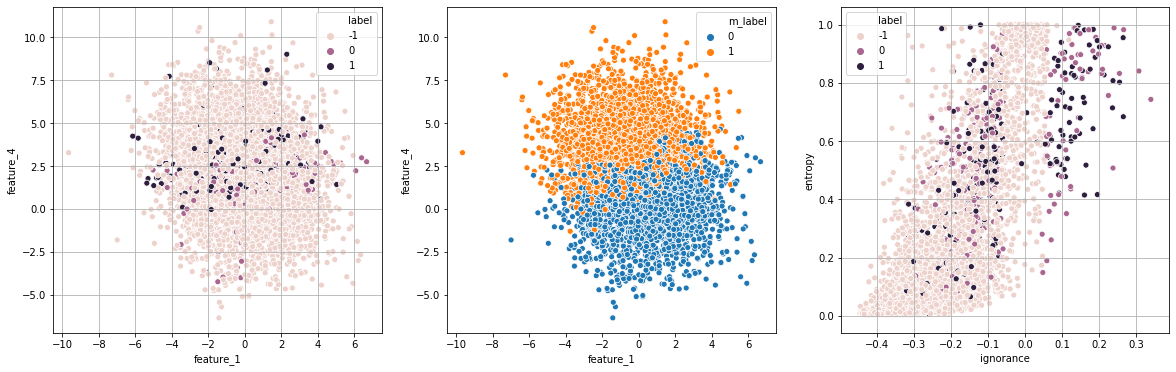

In [147]:
runs = 50
print("Exp 1: entropia")
exp_1 = run_experiment(strategy="entropy",runs=runs,df=df,show=True)
print("Exp 2: ignorância")
exp_2 = run_experiment(strategy="ignorance",runs=runs,df=df,show=True)
print("Exp 3: entropia + ignorância")
exp_3 = run_experiment(strategy="priorisation",runs=runs,df=df,show=True)
print("Exp 4: aleatório")
exp_4 = run_experiment(strategy="random",runs=runs,df=df,show=True)
print("Exp 5: ignorância modificada")
exp_5 = run_modified_experiment(strategy="priorisation",runs=runs,df=df,show=True)
print("Exp 6: entropia + ignorância modificada")
exp_6 = run_modified_experiment(strategy="ignorance",runs=runs,df=df,show=True)

### Para visualizar o resultado de alguns experimentos

In [164]:
%%time
exp_1,exp_2,exp_3,exp_4,exp_5,exp_6 = [[],[],[],[],[],[],]
runs = 100
exp_runs = 10
for i in range(exp_runs):
    print(i+1)
    exp_1.append(run_experiment(strategy="entropy",runs=runs,df=df,show=False))
    exp_2.append(run_experiment(strategy="ignorance",runs=runs,df=df,show=False))
    exp_3.append(run_experiment(strategy="priorisation",runs=runs,df=df,show=False))
    exp_4.append(run_experiment(strategy="random",runs=runs,df=df,show=False))
    exp_5.append(run_modified_experiment(strategy="priorisation",runs=runs,df=df,show=False))
    exp_6.append(run_modified_experiment(strategy="ignorance",runs=runs,df=df,show=False))

exp_1 = np.array(exp_1).mean(axis=0)
exp_2 = np.array(exp_2).mean(axis=0)
exp_3 = np.array(exp_3).mean(axis=0)
exp_4 = np.array(exp_4).mean(axis=0)
exp_5 = np.array(exp_5).mean(axis=0)
exp_6 = np.array(exp_6).mean(axis=0)

CPU times: user 3h 9min 33s, sys: 2h 45min 35s, total: 5h 55min 8s
Wall time: 48min 49s


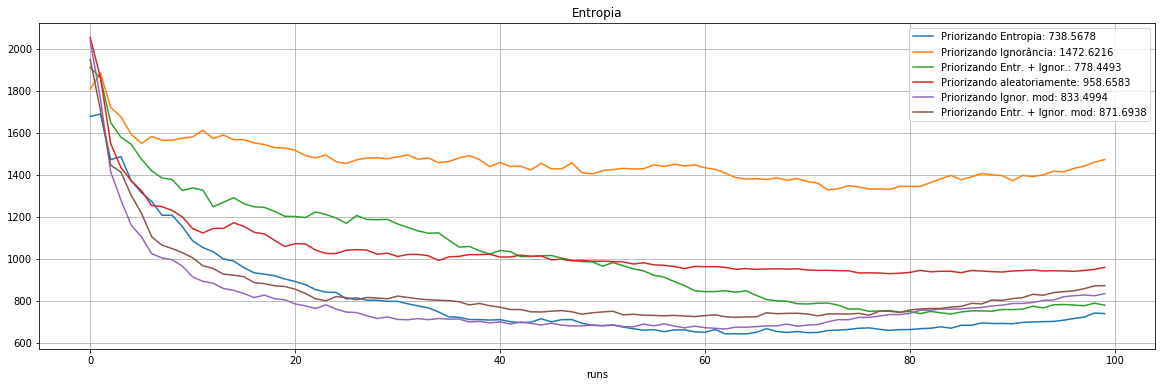

In [165]:
plot_exp([0,"Entropia"])

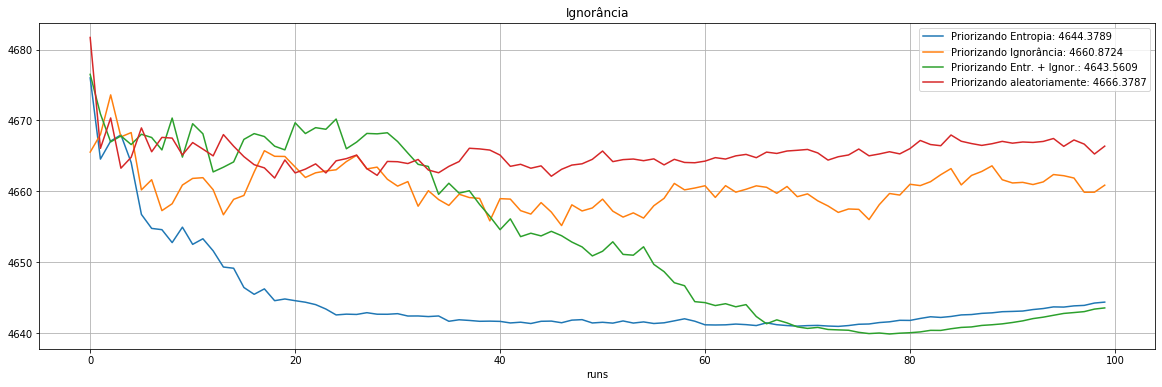

In [166]:
plot_exp([1,"Ignorância"])

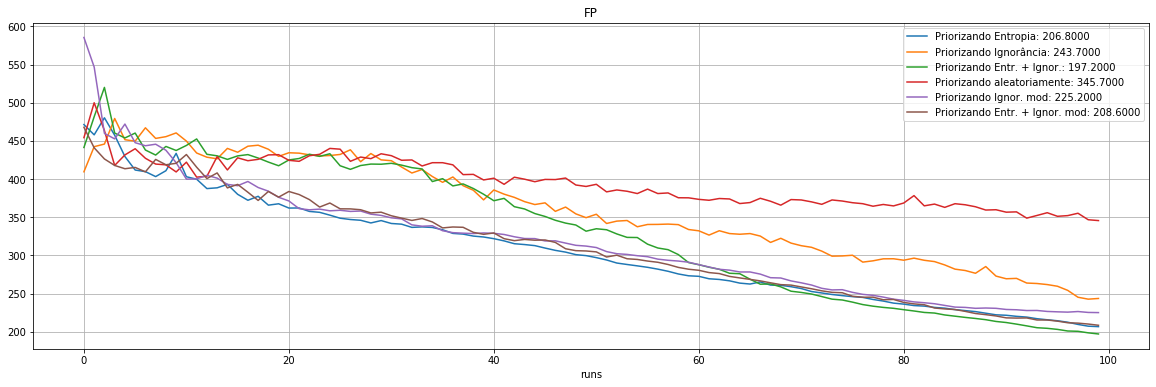

In [167]:
plot_exp([2,"FP"])

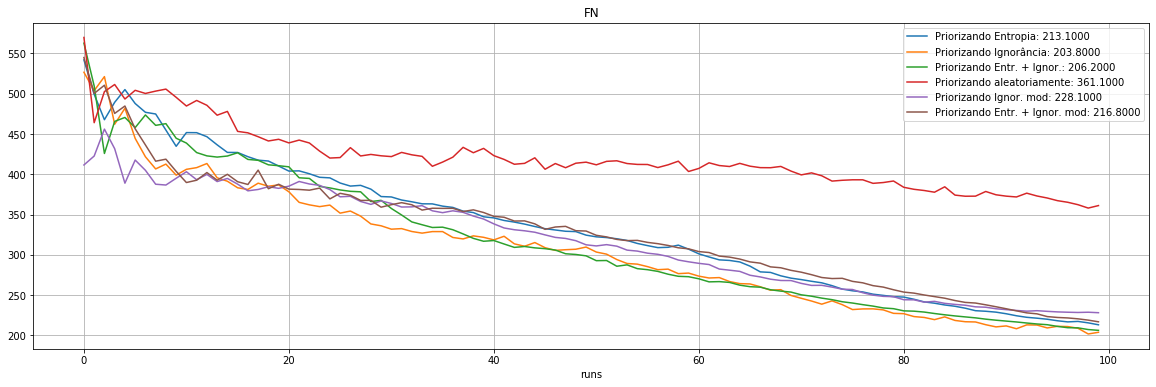

In [168]:
plot_exp([3,"FN"])

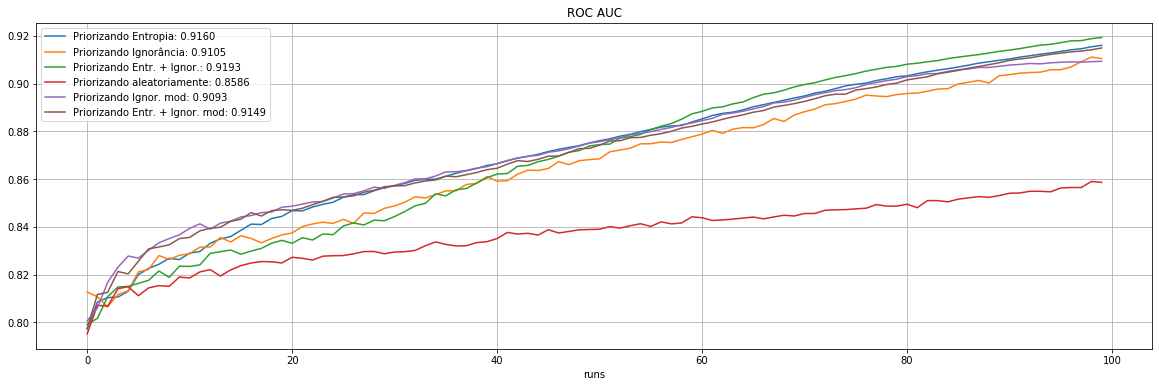

In [169]:
plot_exp([4,"ROC AUC"])

|Experimento |Priorização| ROC AUC | Entropia | Ignorância | FP | FN | Observações rotuladas (% do dataset)|
| --- | --- | --- | --- | --- | --- | --- | --- |
Exp 1| Entropia | 0.9160| **738.6** | **4644.4** | 207| 213| 1050 (21%)|
Exp 2| Ignorância | 0.9105 | 1472.6 | 4660.9 | 244 | **204** | 1050 (21%)|
Exp 3| Entropia + Ignorância | **0.9193** | 778.4 | 4643.6 | **197** | 206 | 1050 (21%)|
Exp 4| Aleatório | 0.8586 | 958.7 | 4666.4| 346 | 361 | 1050 (21%)|
Exp 5|Ignorância modificada| 0.9093 | 833.5 | xxxx | 225 | 228 | 1050 (21%)|
Exp 6| Entropia + Ignorância modificada| 0.9149 | 871.7 | xxxx | 207 | 217 | 1050 (21%)|
